In [25]:
import numpy as np
import geopandas as gpd
import contextily as ctx
import os 
import h3
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import LineString, Polygon, Point
from shapely.strtree import STRtree
from math import pi, cos, sin, exp, sqrt
from geopy.distance import geodesic
from pyproj import Transformer
from itertools import combinations
from math import pi, cos, sin, exp, sqrt, radians, atan2
import statsmodels.api as sm
from scipy.spatial.distance import cdist
import shapely.geometry as geom
import json
import seaborn as sns

# **CALIBRATING EXPRESS GRAVITY (DUBAI DATA)**

In [2]:
raw_df = pd.read_csv('talabat_100000.csv')[['vendor_lat', 'vendor_lng', 'customer_lat', 'customer_lng']]
print(raw_df)

       vendor_lat  vendor_lng  customer_lat  customer_lng
0       25.194229   55.398766     25.229800     55.411000
1       25.113965   55.380591     25.080740     55.355114
2       25.290111   55.404917     25.216903     55.391737
3       25.052800   55.199160     24.992645     55.181140
4       25.090638   55.153320     25.127100     55.153500
...           ...         ...           ...           ...
99995   25.090638   55.153320     25.033714     55.151660
99996   25.225105   55.370870     25.212380     55.315634
99997   25.110157   55.202560     25.102172     55.196202
99998   25.184257   55.260209     25.193671     55.263278
99999   25.046660   55.240070     25.026310     55.248264

[100000 rows x 4 columns]


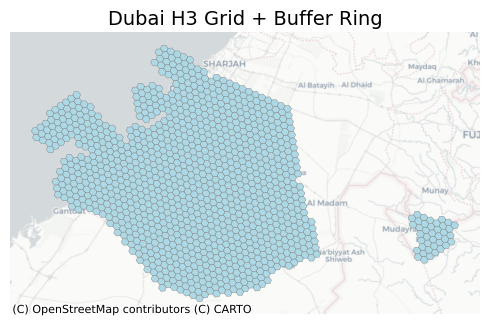

Total candidate H3 cells: 1233
Final hexes (core + buffer): 1154


In [3]:
# --- Step 1: Load and prepare Dubai geometry ---
gdf = gpd.read_file("dubai.geojson")
if gdf.crs != "EPSG:4326":
    gdf = gdf.to_crs("EPSG:4326")

# Dissolve to a single polygon
geometry = gdf.dissolve().geometry.values[0]
polygons = geometry.geoms if geometry.geom_type == "MultiPolygon" else [geometry]

# Convert each polygon to H3 LatLngPoly format
latlng_polys = []
for poly in polygons:
    outer_ring = [[y, x] for x, y in poly.exterior.coords[:]]
    latlng_polys.append(h3.LatLngPoly(outer_ring))

# --- Step 2: Generate H3 cells and 1-ring neighbors ---
all_candidate_cells = set()
for shape in latlng_polys:
    base_cells = h3.polygon_to_cells(shape, res=7)
    candidate_cells = set(base_cells)
    for cell in base_cells:
        candidate_cells.update(h3.grid_ring(cell, 1))  # Add neighbors
    all_candidate_cells.update(candidate_cells)

# Convert H3 cells to Shapely polygons
polygons = [
    Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
    for cell in all_candidate_cells
]
candidate_gdf = gpd.GeoDataFrame(
    {'h3_index': list(all_candidate_cells), 'geometry': polygons},
    crs='EPSG:4326'
)

# --- Step 3: Filter by intersection with Dubai ---
intersecting_hexes = candidate_gdf[candidate_gdf.geometry.intersects(geometry)]

# --- Step 4: Add buffer ring (1 ring of neighboring hexes) ---
# core_hexes = set(intersecting_hexes['h3_index'])
# buffer_hexes = set()
# for h in core_hexes:
#     buffer_hexes.update(h3.grid_ring(h, 1))
# outer_ring_hexes = buffer_hexes - core_hexes

# Create GeoDataFrame for buffer hexes
# extra_polygons = [
#     Polygon([(lng, lat) for lat, lng in h3.cell_to_boundary(cell)])
#     for cell in intersecting_hexes
# ]
# extra_gdf = gpd.GeoDataFrame(
#     {'h3_index': list(intersecting_hexes), 'geometry': extra_polygons},
#     crs='EPSG:4326'
# )

# # Combine core and buffer hexes
# intersecting_hexes = pd.concat([intersecting_hexes, extra_gdf], ignore_index=True)

# --- Step 5: Reproject to Web Mercator for basemap ---
intersecting_hexes_3857 = intersecting_hexes.to_crs(epsg=3857)

# --- Step 6: Plot with basemap ---
fig, ax = plt.subplots(figsize=(5, 5))
intersecting_hexes_3857.plot(
    ax=ax, edgecolor='gray', facecolor='lightblue', linewidth=0.3
)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)  # Add clean street basemap
ax.set_axis_off()
plt.title("Dubai H3 Grid + Buffer Ring", fontsize=14)
plt.tight_layout()
plt.show()

# --- Optional: Summary ---
print(f"Total candidate H3 cells: {len(all_candidate_cells)}")
print(f"Final hexes (core + buffer): {len(intersecting_hexes)}")


In [4]:
# --- Step 1: Assign H3 index to vendors and customers using latlng_to_cell ---
res = 7  # match resolution to intersecting_hexes

raw_df['vendor_h3'] = raw_df.apply(
    lambda row: h3.latlng_to_cell(row['vendor_lat'], row['vendor_lng'], res), axis=1)
raw_df['customer_h3'] = raw_df.apply(
    lambda row: h3.latlng_to_cell(row['customer_lat'], row['customer_lng'], res), axis=1)

# --- Step 2: Count vendors and customers per H3 cell ---
vendor_counts = raw_df['vendor_h3'].value_counts().rename_axis('h3_index').reset_index(name='num_vendors')
customer_counts = raw_df['customer_h3'].value_counts().rename_axis('h3_index').reset_index(name='num_customers')

# --- Step 3: Merge counts into intersecting_hexes ---
intersecting_hexes['h3_index'] = intersecting_hexes['h3_index'].astype(str)
merged = intersecting_hexes.merge(vendor_counts, on='h3_index', how='left')
merged = merged.merge(customer_counts, on='h3_index', how='left')

# Fill NaNs with 0
merged['num_vendors'] = merged['num_vendors'].fillna(0).astype(int)
merged['num_customers'] = merged['num_customers'].fillna(0).astype(int)

# --- Step 4: Add centroid geometry ---
merged['centroid'] = merged.geometry.centroid

/opt/anaconda3/envs/ox/lib/python3.13/site-packages/geopandas/geodataframe.py:1981: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35823/830668469.py:23: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged['centroid'] = merged.geometry.centroid


In [5]:
merged = merged.loc[~((merged['num_vendors'] == 0) & (merged['num_customers'] == 0))].copy()

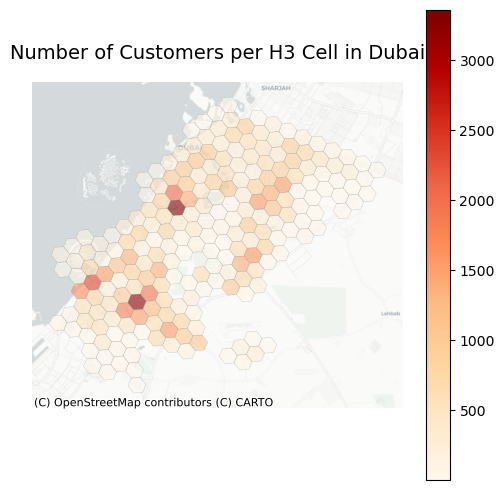

In [6]:
# Step 1: Reproject to EPSG:3857 for basemap compatibility
merged_3857 = merged.to_crs(epsg=3857)

merged_3857['centroid'] = merged_3857.geometry.centroid

# Step 2: Plot
fig, ax = plt.subplots(figsize=(5, 5))
merged_3857.plot(
    column='num_customers',
    ax=ax,
    legend=True,
    cmap='OrRd',
    alpha=0.6,
    edgecolor='grey',
    linewidth=0.2,
    missing_kwds={"color": "lightgrey"},
)

# Step 3: Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Final touches
ax.set_axis_off()
plt.title("Number of Customers per H3 Cell in Dubai", fontsize=14)
plt.tight_layout()
plt.show()


In [7]:
# Step 1: Ensure vendor_h3 and customer_h3 are assigned (resolution 7)
res = 7
raw_df['vendor_h3'] = raw_df.apply(
    lambda row: h3.latlng_to_cell(row['vendor_lat'], row['vendor_lng'], res), axis=1)
raw_df['customer_h3'] = raw_df.apply(
    lambda row: h3.latlng_to_cell(row['customer_lat'], row['customer_lng'], res), axis=1)

# Step 2: Create symmetric pairs by sorting the hex IDs of origin and destination
def sorted_pair(row):
    return tuple(sorted([row['vendor_h3'], row['customer_h3']]))

raw_df['sym_pair'] = raw_df.apply(sorted_pair, axis=1)

# Step 3: Count orders per symmetric pair
pair_counts = raw_df.groupby('sym_pair').size().reset_index(name='order_count')

# Step 4: Extract unique hex IDs to build matrix axes
unique_hexes = pd.Index(
    pd.unique(pair_counts['sym_pair'].explode())
).sort_values()

# Step 5: Initialize empty DataFrame for OD matrix
od_matrix = pd.DataFrame(
    data=0,
    index=unique_hexes,
    columns=unique_hexes,
    dtype=int
)

# Step 6: Fill matrix with counts for each pair
for _, row in pair_counts.iterrows():
    origin, dest = row['sym_pair']
    count = row['order_count']
    od_matrix.at[origin, dest] = count
    od_matrix.at[dest, origin] = count  # symmetric

od_matrix


,8743a1200ffffff,8743a1201ffffff,8743a1202ffffff,8743a1203ffffff,8743a1204ffffff,8743a1205ffffff,8743a1206ffffff,8743a1219ffffff,8743a1220ffffff,8743a1221ffffff,...,8743accf6ffffff,8743acd8affffff,8743acd8bffffff,8743acd92ffffff,8743acd93ffffff,8743acd98ffffff,8743acd99ffffff,8743acd9affffff,8743acd9bffffff,8743acd9effffff
8743a1200ffffff,0,0,0,0,0,0,0,0,980,0,...,0,0,0,0,0,0,0,0,0,0
8743a1201ffffff,0,0,0,0,0,0,0,0,284,0,...,0,0,0,0,0,0,0,0,0,0
8743a1202ffffff,0,0,0,0,0,0,0,0,163,0,...,0,0,0,0,0,0,0,0,0,0
8743a1203ffffff,0,0,0,0,0,0,0,0,1050,0,...,0,0,0,0,0,0,0,0,0,0
8743a1204ffffff,0,0,0,0,0,0,0,0,1538,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8743acd98ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8743acd99ffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8743acd9affffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8743acd9bffffff,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Step 1: Check original CRS
print(merged_3857.crs)  # likely EPSG:3857 (meters)

# Step 2: Reproject to EPSG:4326 (WGS 84 in degrees)
merged_4326 = merged_3857.to_crs(epsg=4326).copy()

# Step 3: Recompute centroids in WGS 84
merged_4326['centroid'] = merged_4326.geometry.centroid

# Step 4: Extract lat/lon from centroid
merged_4326['lat'] = merged_4326['centroid'].y
merged_4326['lon'] = merged_4326['centroid'].x

EPSG:3857


/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35823/2354708905.py:8: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_4326['centroid'] = merged_4326.geometry.centroid


In [9]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1 - a))

# Step 1: Reproject from EPSG:3857 to WGS84 (EPSG:4326)
merged_4326 = merged_3857.to_crs(epsg=4326).copy()

# Step 2: Recompute centroids in WGS84
merged_4326['centroid'] = merged_4326.geometry.centroid
merged_4326['lat'] = merged_4326['centroid'].y
merged_4326['lon'] = merged_4326['centroid'].x

# Step 3: Align index and prepare coordinate lists
merged_4326 = merged_4326.set_index('h3_index')
hex_ids = merged_4326.index.tolist()
lats = merged_4326['lat'].values
lons = merged_4326['lon'].values
n = len(hex_ids)

# Step 4: Compute pairwise Haversine distance matrix
cost_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        cost_matrix[i, j] = haversine(lats[i], lons[i], lats[j], lons[j])

# Step 5: Return as DataFrame with hex IDs as index/columns
cost_df = pd.DataFrame(cost_matrix, index=hex_ids, columns=hex_ids)

# 2. Prepare OD pairs DataFrame for modeling
# Flatten od_matrix and cost_df to long format
od_long = od_matrix.stack().rename('flow').reset_index()
od_long.columns = ['origin', 'destination', 'flow']

cost_long = cost_df.stack().rename('cost').reset_index()
cost_long.columns = ['origin', 'destination', 'cost']

# Merge flows and costs
df = pd.merge(od_long, cost_long, on=['origin', 'destination'])

# Filter out zero flows to avoid log(0) issues in regression
df = df[df['flow'] > 0].copy()

# Calculate total outflows and inflows per zone
O = od_matrix.sum(axis=1).rename('O')
D = od_matrix.sum(axis=0).rename('D')

df = df.merge(O, left_on='origin', right_index=True)
df = df.merge(D, left_on='destination', right_index=True)

# 3. Estimate beta using Poisson regression
# Model: flow ~ log(O) + log(D) + cost (no intercept)

df['log_O'] = np.log(df['O'])
df['log_D'] = np.log(df['D'])
df['log_cost'] = np.log(df['cost'] * 1000 + 1)

X = df[['log_O', 'log_D', 'cost']]
# no intercept to keep multiplicative model consistent
model = sm.GLM(df['flow'], X, family=sm.families.Poisson())
result = model.fit()

print(result.summary())

beta = result.params['cost']
print(f'Estimated beta: {beta:.4f}')

# 4. Run iterative proportional fitting (IPF) to get balancing factors A_i and B_j
# Initialize A and B
O_vec = O.values
D_vec = D.values
cost_exp = np.exp(-beta * cost_matrix)

A = np.ones_like(O_vec)
B = np.ones_like(D_vec)

# IPF iterations
max_iter = 1000
tol = 1e-6

for iteration in range(max_iter):
    A_prev = A.copy()
    B_prev = B.copy()

    # Update A
    denom_A = cost_exp.dot(B * D_vec)
    A = 1 / denom_A

    # Update B
    denom_B = cost_exp.T.dot(A * O_vec)
    B = 1 / denom_B

    # Check convergence
    if np.allclose(A, A_prev, atol=tol) and np.allclose(B, B_prev, atol=tol):
        print(f'IPF converged in {iteration+1} iterations')
        break
else:
    print('IPF did not converge within the max iterations')

# Compute final predicted flows
T_hat = np.outer(A * O_vec, B * D_vec) * cost_exp

# Convert predicted flows to DataFrame
T_hat_df = pd.DataFrame(T_hat, index=od_matrix.index, columns=od_matrix.columns)

# Optional: Compare observed vs predicted total flows
print('Observed total flow:', od_matrix.values.sum())
print('Predicted total flow:', T_hat_df.values.sum())

# Your predicted flows are in T_hat_df


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   flow   No. Observations:                  822
Model:                            GLM   Df Residuals:                      819
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -77576.
Date:                Wed, 09 Jul 2025   Deviance:                   1.5060e+05
Time:                        21:38:39   Pearson chi2:                 1.57e+05
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_O          0.4245      0.001    453.820      0.0

/var/folders/n6/07flntc946j046ynznszq86w0000gn/T/ipykernel_35823/2209510442.py:14: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  merged_4326['centroid'] = merged_4326.geometry.centroid


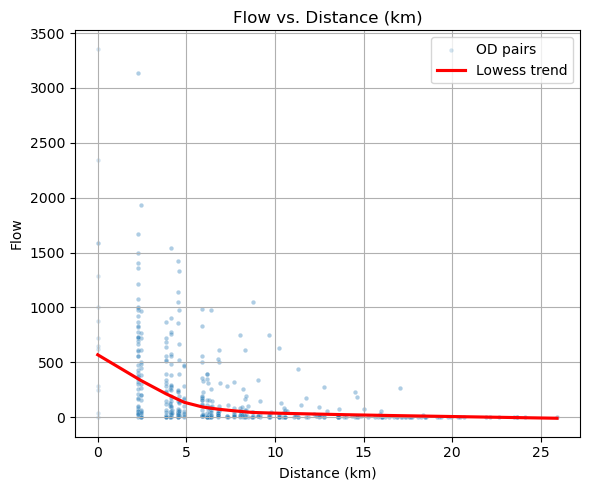

In [ ]:
# Flatten OD and cost matrices to long format
flow_long = od_matrix.stack().rename('flow').reset_index()
flow_long.columns = ['origin', 'destination', 'flow']

cost_long = cost_df.stack().rename('cost_km').reset_index()
cost_long.columns = ['origin', 'destination', 'cost_km']

# Merge flows and distances
merged = pd.merge(flow_long, cost_long, on=['origin', 'destination'])

# Filter to non-zero flows only
merged = merged[merged['flow'] > 0]

# Plot
plt.figure(figsize=(5, 4))
sns.scatterplot(data=merged, x='cost_km', y='flow', alpha=0.2, s=10, label='OD pairs')
sns.regplot(data=merged, x='cost_km', y='flow', scatter=False, 
            lowess=True, color='red', label='Lowess trend')

plt.title('Flow vs. Distance (km)')
plt.xlabel('Distance (km)')
plt.ylabel('Flow')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **CALIBRATING SCHEDULED GRAVITY (FAILED ATTEMPTS)**

In [ ]:
lade_pickup = pd.read_csv('../data/lade_data/lade_pickup_sh.csv')
lade_pickup

,order_id,region_id,city,courier_id,accept_time,time_window_start,time_window_end,lng,lat,aoi_id,aoi_type,pickup_time,pickup_gps_time,pickup_gps_lng,pickup_gps_lat,accept_gps_time,accept_gps_lng,accept_gps_lat,ds
0,2349637,0,Shanghai,1448,07-08 08:13:00,07-08 09:00:00,07-08 11:00:00,121.52223,30.90747,46,14,07-08 10:10:00,07-08 10:10:00,121.52208,30.90836,NaN,NaN,NaN,708
1,4867696,0,Shanghai,1448,07-21 08:14:00,07-21 09:00:00,07-21 11:00:00,121.52223,30.90742,46,14,07-21 10:10:00,07-21 10:10:00,121.52689,30.91897,07-21 08:14:00,121.50334,30.90424,721
2,5691514,0,Shanghai,1448,07-12 07:40:00,07-12 17:00:00,07-12 19:00:00,121.52229,30.90731,46,14,07-12 17:22:00,07-12 17:22:00,121.52612,30.91764,07-12 07:37:00,121.49739,30.90695,712
3,1443776,0,Shanghai,1448,07-09 15:38:00,07-09 17:00:00,07-09 19:00:00,121.52234,30.90749,46,14,07-09 15:54:00,07-09 15:54:00,121.52316,30.90876,07-09 15:38:00,121.51814,30.90612,709
4,1806717,0,Shanghai,1448,07-07 07:25:00,07-07 09:00:00,07-07 11:00:00,121.52230,30.90747,46,14,07-07 09:53:00,07-07 09:53:00,121.51871,30.90687,07-07 07:25:00,121.49736,30.90752,707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424401,2376930,67,Shanghai,15146,09-16 11:36:00,09-16 13:00:00,09-16 15:00:00,121.61411,31.20522,24428,14,09-16 13:27:00,09-16 13:27:00,121.63303,31.19924,09-16 11:35:00,121.62867,31.20045,916
1424402,1872604,67,Shanghai,15406,10-08 08:23:00,10-08 09:00:00,10-08 11:00:00,121.61416,31.20526,24428,14,10-08 10:39:00,NaN,NaN,NaN,NaN,NaN,NaN,1008
1424403,2633330,67,Shanghai,15406,10-25 09:05:00,10-25 11:00:00,10-25 13:00:00,121.61412,31.20529,24428,14,10-25 12:56:00,NaN,NaN,NaN,NaN,NaN,NaN,1025
1424404,4363494,67,Shanghai,15406,10-20 07:58:00,10-20 09:00:00,10-20 11:00:00,121.61448,31.20549,24428,14,10-20 09:47:00,NaN,NaN,NaN,NaN,NaN,NaN,1020


In [ ]:
lade_delivery = pd.read_csv('../data/lade_data/lade_delivery_sh.csv')
lade_delivery

,order_id,region_id,city,courier_id,lng,lat,aoi_id,aoi_type,accept_time,accept_gps_time,accept_gps_lng,accept_gps_lat,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds
0,3158819,1,Shanghai,164,121.52128,31.06614,450,1,06-04 11:05:00,06-04 11:05:00,121.52281,31.10598,06-04 17:40:00,06-04 17:40:00,121.52407,31.06614,604
1,751342,1,Shanghai,164,121.52124,31.06687,450,1,06-04 11:18:00,06-04 11:18:00,121.52286,31.10599,06-04 15:06:00,06-04 15:06:00,121.52412,31.06618,604
2,3380476,1,Shanghai,164,121.52106,31.06731,450,1,06-03 10:13:00,06-03 10:13:00,121.52285,31.10591,06-03 15:11:00,06-03 15:11:00,121.52059,31.06672,603
3,2184571,1,Shanghai,164,121.52128,31.06616,450,1,06-04 10:39:00,06-04 10:39:00,121.52282,31.10593,06-04 15:41:00,06-04 15:41:00,121.52280,31.10542,604
4,941371,1,Shanghai,164,121.52123,31.06614,450,1,06-04 11:18:00,06-04 11:18:00,121.52285,31.10593,06-04 14:07:00,06-04 14:07:00,121.52290,31.06758,604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483859,960937,93,Shanghai,2690,121.55559,31.07807,60110,14,10-22 13:28:00,10-22 13:28:00,121.52749,31.06045,10-22 16:37:00,10-22 16:37:00,121.56303,31.07953,1022
1483860,3894541,93,Shanghai,2690,121.55567,31.07864,60110,14,10-21 13:53:00,10-21 13:53:00,121.52737,31.06047,10-21 14:21:00,10-21 14:21:00,121.55509,31.07841,1021
1483861,3946912,93,Shanghai,2690,121.55574,31.07873,60110,14,10-20 08:56:00,10-20 08:56:00,121.52742,31.06046,10-20 09:12:00,10-20 09:12:00,121.55703,31.07842,1020
1483862,1320044,93,Shanghai,2690,121.55565,31.07866,60110,14,10-18 15:07:00,10-18 15:07:00,121.52732,31.06045,10-18 16:54:00,10-18 16:54:00,121.55643,31.08042,1018


In [ ]:
lade_joined = pd.merge(lade_pickup, lade_delivery, how='inner', on=['accept_gps_lng', 'accept_gps_lat'])

,order_id_x,region_id_x,city_x,courier_id_x,accept_time_x,time_window_start,time_window_end,lng_x,lat_x,aoi_id_x,...,lat_y,aoi_id_y,aoi_type_y,accept_time_y,accept_gps_time_y,delivery_time,delivery_gps_time,delivery_gps_lng,delivery_gps_lat,ds_y
0,4623603,28,Shanghai,15341,06-15 10:14:00,06-15 11:00:00,06-15 13:00:00,121.25852,31.17647,17205,...,31.15960,1244,1,06-28 09:20:00,06-28 09:20:00,06-28 12:00:00,06-28 12:00:00,121.27111,31.16101,628
1,4623603,28,Shanghai,15341,06-15 10:14:00,06-15 11:00:00,06-15 13:00:00,121.25852,31.17647,17205,...,31.16040,1244,1,05-05 14:42:00,05-05 14:42:00,05-05 19:39:00,05-05 19:39:00,121.36244,31.20055,505
2,4623603,28,Shanghai,15341,06-15 10:14:00,06-15 11:00:00,06-15 13:00:00,121.25852,31.17647,17205,...,31.16922,5011,1,06-19 13:43:00,06-19 13:43:00,06-19 14:16:00,06-19 14:16:00,121.29155,31.17011,619
3,4623603,28,Shanghai,15341,06-15 10:14:00,06-15 11:00:00,06-15 13:00:00,121.25852,31.17647,17205,...,31.15607,7136,1,08-20 13:20:00,08-20 13:20:00,08-20 15:26:00,08-20 15:26:00,121.27080,31.16750,820
4,4623603,28,Shanghai,15341,06-15 10:14:00,06-15 11:00:00,06-15 13:00:00,121.25852,31.17647,17205,...,31.16583,10725,1,09-16 19:47:00,09-16 19:47:00,09-16 19:48:00,09-16 19:48:00,121.24915,31.18829,916
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,695677,39,Shanghai,478,07-02 09:01:00,07-02 15:00:00,07-02 17:00:00,121.69625,31.21463,13291,...,31.21852,58761,1,08-31 21:21:00,08-31 21:21:00,08-31 21:21:00,08-31 21:21:00,121.65477,31.22029,831
836,695677,39,Shanghai,478,07-02 09:01:00,07-02 15:00:00,07-02 17:00:00,121.69625,31.21463,13291,...,31.21817,58761,1,07-04 16:55:00,07-04 16:55:00,07-04 19:55:00,07-04 19:55:00,121.65453,31.22027,704
837,695677,39,Shanghai,478,07-02 09:01:00,07-02 15:00:00,07-02 17:00:00,121.69625,31.21463,13291,...,31.21873,58761,1,08-03 18:01:00,08-03 18:01:00,08-03 20:35:00,08-03 20:35:00,121.65330,31.21794,803
838,695677,39,Shanghai,478,07-02 09:01:00,07-02 15:00:00,07-02 17:00:00,121.69625,31.21463,13291,...,31.23111,59083,14,08-21 18:10:00,08-21 18:10:00,08-21 18:43:00,08-21 18:43:00,121.68972,31.23148,821


In [14]:
amazon_df = pd.read_csv('amazon_delivery.csv')[['Order_ID', 'Store_Latitude',
       'Store_Longitude', 'Drop_Latitude', 'Drop_Longitude', 'Order_Date',
       'Order_Time', 'Pickup_Time', 'Vehicle', 'Delivery_Time', 'Category']]
amazon_df

,Order_ID,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Vehicle,Delivery_Time,Category
0,ialx566343618,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,motorcycle,120,Clothing
1,akqg208421122,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,scooter,165,Electronics
2,njpu434582536,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,motorcycle,130,Sports
3,rjto796129700,11.003669,76.976494,11.053669,77.026494,2022-04-05,18:00:00,18:10:00,motorcycle,105,Cosmetics
4,zguw716275638,12.972793,80.249982,13.012793,80.289982,2022-03-26,13:30:00,13:45:00,scooter,150,Toys
...,...,...,...,...,...,...,...,...,...,...,...
43734,jlxf819993117,26.902328,75.794257,26.912328,75.804257,2022-03-24,11:35:00,11:45:00,motorcycle,160,Home
43735,aevx342135787,0.000000,0.000000,0.070000,0.070000,2022-02-16,19:55:00,20:10:00,motorcycle,180,Jewelry
43736,xnek760674819,13.022394,80.242439,13.052394,80.272439,2022-03-11,23:50:00,00:05:00,scooter,80,Home
43737,cynl434665991,11.001753,76.986241,11.041753,77.026241,2022-03-07,13:35:00,13:40:00,motorcycle,130,Kitchen


In [15]:
amazon_df = amazon_df[amazon_df['Vehicle']=='van']
amazon_df = amazon_df[amazon_df['Category']!='Grocery']
amazon_df = amazon_df[amazon_df['Category']!='Kitchen']

In [16]:
amazon_df

,Order_ID,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Order_Date,Order_Time,Pickup_Time,Vehicle,Delivery_Time,Category
14,zyvo118176215,19.176269,72.836721,19.266269,72.926721,2022-04-02,20:25:00,20:35:00,van,100,Outdoors
20,pbjm971961647,23.357804,85.325146,23.487804,85.455146,2022-03-10,22:30:00,22:45:00,van,130,Books
24,owvs520891091,13.005801,80.250744,13.115801,80.360744,2022-03-27,18:35:00,18:50:00,van,75,Outdoors
28,xjps180812498,18.514210,73.838429,18.624210,73.948429,2022-04-02,23:35:00,23:45:00,van,60,Jewelry
45,rxgx102974679,19.221315,72.862381,19.281315,72.922381,2022-03-24,21:40:00,21:45:00,van,55,Apparel
...,...,...,...,...,...,...,...,...,...,...,...
43680,ncnn455761178,30.335259,78.053162,30.415259,78.133162,2022-02-16,18:55:00,19:05:00,van,110,Outdoors
43709,mpbz498193455,30.340722,78.060221,30.470722,78.190221,2022-02-12,19:35:00,19:45:00,van,135,Clothing
43716,porw124204768,19.875908,75.358888,19.895908,75.378888,2022-02-11,09:30:00,09:45:00,van,60,Cosmetics
43729,llbw528617620,12.310972,76.659264,12.440972,76.789264,2022-03-18,21:10:00,21:20:00,van,145,Sports


In [18]:
# Drop rows with invalid coordinates
df = amazon_df.copy()
df = df[(df['Store_Latitude'] != 0) & (df['Store_Longitude'] != 0)]
df = df[(df['Drop_Latitude'] != 0) & (df['Drop_Longitude'] != 0)]

# Assign H3 zones at resolution 7
df['origin'] = df.apply(lambda row: h3.latlng_to_cell(row['Store_Latitude'], row['Store_Longitude'], 7), axis=1)
df['destination'] = df.apply(lambda row: h3.latlng_to_cell(row['Drop_Latitude'], row['Drop_Longitude'], 7), axis=1)

# Build OD matrix: Count of deliveries from origin to destination
od_matrix = df.groupby(['origin', 'destination']).size().unstack(fill_value=0)

# Extract unique hex zones
unique_hexes = list(set(od_matrix.index) | set(od_matrix.columns))

# Convert to lat/lon centroids
centroids = [h3.cell_to_latlng(h) for h in unique_hexes]
lat_lon_df = pd.DataFrame(centroids, columns=['lat', 'lon'], index=unique_hexes)


In [ ]:
res = 7

# Filter invalid points if needed
df = df[
    (df['Store_Latitude'] != 0) & (df['Store_Longitude'] != 0) &
    (df['Drop_Latitude'] != 0) & (df['Drop_Longitude'] != 0)
].copy()

# Assign origin and destination hexes
df['origin_h3'] = df.apply(
    lambda row: h3.latlng_to_cell(row['Store_Latitude'], row['Store_Longitude'], res), axis=1)
df['dest_h3'] = df.apply(
    lambda row: h3.latlng_to_cell(row['Drop_Latitude'], row['Drop_Longitude'], res), axis=1)

# Convert points to GeoDataFrames
gdf_origin = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Store_Longitude'], df['Store_Latitude']),
    crs='EPSG:4326'
)

gdf_dest = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['Drop_Longitude'], df['Drop_Latitude']),
    crs='EPSG:4326'
)

unique_hexes = set(df['origin_h3']).union(set(df['dest_h3']))

# Convert hex to shapely polygon
def hex_to_polygon(h):
    boundary_latlng = h3.cell_to_boundary(h)  # returns list of (lat, lng)
    # Swap to (lng, lat) for shapely
    boundary = [(lng, lat) for lat, lng in boundary_latlng]
    return geom.Polygon(boundary)

hex_polygons = [hex_to_polygon(h) for h in unique_hexes]

gdf_hex = gpd.GeoDataFrame({'h3_index': list(unique_hexes), 'geometry': hex_polygons}, crs='EPSG:4326')

# Reproject to UTM zone 43N for India (EPSG:32643)
gdf_origin_utm = gdf_origin.to_crs(epsg=32643)
gdf_dest_utm = gdf_dest.to_crs(epsg=32643)
gdf_hex_utm = gdf_hex.to_crs(epsg=32643)

print(gdf_origin_utm.head())
print(gdf_dest_utm.head())
print(gdf_hex_utm.head())


         Order_ID  Store_Latitude  Store_Longitude  Drop_Latitude  \
14  zyvo118176215       19.176269        72.836721      19.266269   
20  pbjm971961647       23.357804        85.325146      23.487804   
24  owvs520891091       13.005801        80.250744      13.115801   
28  xjps180812498       18.514210        73.838429      18.624210   
45  rxgx102974679       19.221315        72.862381      19.281315   

    Drop_Longitude  Order_Date Order_Time Pickup_Time Vehicle  Delivery_Time  \
14       72.926721  2022-04-02   20:25:00    20:35:00     van            100   
20       85.455146  2022-03-10   22:30:00    22:45:00     van            130   
24       80.360744  2022-03-27   18:35:00    18:50:00     van             75   
28       73.948429  2022-04-02   23:35:00    23:45:00     van             60   
45       72.922381  2022-03-24   21:40:00    21:45:00     van             55   

    Category           origin      destination        origin_h3  \
14  Outdoors  87608b463ffffff  87608b

In [20]:
od_counts = df.groupby(['origin_h3', 'dest_h3']).size().unstack(fill_value=0)

gdf_hex_utm['centroid'] = gdf_hex_utm.geometry.centroid
gdf_hex_utm['centroid_x'] = gdf_hex_utm.centroid.x
gdf_hex_utm['centroid_y'] = gdf_hex_utm.centroid.y

In [21]:

hex_ids = gdf_hex_utm['h3_index'].tolist()
centroids = gdf_hex_utm.set_index('h3_index')[['centroid_x', 'centroid_y']]

n = len(hex_ids)
dist_matrix = np.zeros((n, n))

for i, h1 in enumerate(hex_ids):
    for j, h2 in enumerate(hex_ids):
        dx = centroids.loc[h1, 'centroid_x'] - centroids.loc[h2, 'centroid_x']
        dy = centroids.loc[h1, 'centroid_y'] - centroids.loc[h2, 'centroid_y']
        dist_matrix[i, j] = np.sqrt(dx*dx + dy*dy)

In [22]:
# 1. Prepare the OD flow data in long format
od_long = od_counts.stack().rename('flow').reset_index()
od_long.columns = ['origin', 'destination', 'flow']

# 2. Prepare distance matrix in long format
dist_df = pd.DataFrame(dist_matrix, index=hex_ids, columns=hex_ids)
dist_long = dist_df.stack().rename('distance').reset_index()
dist_long.columns = ['origin', 'destination', 'distance']

# 3. Merge flow and distance data
df_model = pd.merge(od_long, dist_long, on=['origin', 'destination'])

# 4. Calculate total outflows and inflows per hex
O = od_counts.sum(axis=1).rename('O')
D = od_counts.sum(axis=0).rename('D')

df_model = df_model.merge(O, left_on='origin', right_index=True)
df_model = df_model.merge(D, left_on='destination', right_index=True)

# 5. Replace zero flows with a small positive value (to avoid log(0))
# df_model['flow'] = df_model['flow'].replace(0, 1e-4)
df_model = df_model[df_model['distance'] <= 50000]

# 6. Prepare variables for regression
df_model['log_O'] = np.log(df_model['O'])
df_model['log_D'] = np.log(df_model['D'])
df_model['log_dist'] = np.log(df_model['distance'] + 1)  # add 1 to avoid log(0)

X = sm.add_constant(df_model[['log_O', 'log_D', 'log_dist']])
y = df_model['flow']

# Add a constant intercept term (optional)
X = sm.add_constant(X)

# 7. Fit Poisson regression model (gravity model)
poisson_model = sm.GLM(y, X, family=sm.families.Poisson())
result = poisson_model.fit()

print(result.summary())

# 8. Extract parameters
beta_dist = result.params['log_dist']
print(f"\nEstimated distance decay parameter (beta_dist): {beta_dist:.4f}")

# The model form is:
# flow ~ exp(const + alpha*log_O + gamma*log_D + beta_dist*log_dist)


                 Generalized Linear Model Regression Results                  
Dep. Variable:                   flow   No. Observations:                 7117
Model:                            GLM   Df Residuals:                     7113
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5476.9
Date:                Wed, 09 Jul 2025   Deviance:                       8002.8
Time:                        21:38:57   Pearson chi2:                 1.44e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.4203
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.4242      0.128    -26.786      0.0

# **CALIBRATING SCHEDULED GRAVITY (AMAZON US)**

In [29]:
data_dir = data_dir = os.path.expanduser('~/.rc-cli/data/model_build_inputs/')

file_path = os.path.join(data_dir, 'route_data.json')
with open(file_path, 'r') as f:
    data = json.load(f)

# Option 1: if it's a list of records
amazon_df = pd.json_normalize(data)
amazon_df = pd.DataFrame(data).transpose()
amazon_df

,station_code,date_YYYY_MM_DD,departure_time_utc,executor_capacity_cm3,route_score,stops
RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,DLA3,2018-07-27,16:02:10,3313071.0,High,"{'AD': {'lat': 34.099611, 'lng': -118.283062, ..."
RouteID_0016bc70-cb8d-48b0-aa55-8ee50bdcdb59,DSE4,2018-07-28,15:44:41,4247527.0,High,"{'AC': {'lat': 47.689446, 'lng': -122.296071, ..."
RouteID_001948e9-4675-486d-9ec5-912fd8e0770f,DSE5,2018-08-18,15:32:04,4247527.0,High,"{'AA': {'lat': 47.268001, 'lng': -122.5079, 't..."
RouteID_001b4ee3-c4f2-467f-932b-c85524d1021f,DLA9,2018-08-15,15:09:38,3313071.0,High,"{'AB': {'lat': 33.823076, 'lng': -118.058727, ..."
RouteID_0021a2aa-780f-460d-b09a-f301709e2523,DLA7,2018-08-05,14:23:26,3313071.0,High,"{'AA': {'lat': 33.84364, 'lng': -117.773651, '..."
...,...,...,...,...,...,...
RouteID_ffd16e94-e3db-435f-a128-1ddcb2a34e54,DAU1,2018-07-24,13:47:59,4247527.0,Medium,"{'AA': {'lat': 30.292536, 'lng': -97.745191, '..."
RouteID_ffe98097-93df-44b0-9c45-4fedbafae3f3,DCH4,2018-08-10,14:07:25,3313071.0,Medium,"{'AC': {'lat': 42.187711, 'lng': -88.262079, '..."
RouteID_ffebb6fc-ce81-46db-b2a1-2750c0333185,DCH3,2018-07-25,14:10:26,3313071.0,High,"{'AA': {'lat': 41.858479, 'lng': -88.322974, '..."
RouteID_fff2548c-1069-4340-8e50-08420efe435d,DLA8,2018-07-29,15:13:39,4247527.0,High,"{'AQ': {'lat': 34.065987, 'lng': -118.363671, ..."


In [30]:
def extract_coords(stops_dict):
    station_coord = None
    dropoffs = []
    for stop in stops_dict.values():
        if stop['type'] == 'Station':
            station_coord = (stop['lat'], stop['lng'])
        elif stop['type'] == 'Dropoff':
            dropoffs.append((stop['lat'], stop['lng']))
    return pd.Series([station_coord, dropoffs])

amazon_df[['station', 'dropoffs']] = amazon_df['stops'].apply(extract_coords)
amazon_df

,station_code,date_YYYY_MM_DD,departure_time_utc,executor_capacity_cm3,route_score,stops,station,dropoffs
RouteID_00143bdd-0a6b-49ec-bb35-36593d303e77,DLA3,2018-07-27,16:02:10,3313071.0,High,"{'AD': {'lat': 34.099611, 'lng': -118.283062, ...","(34.007369, -118.143927)","[(34.099611, -118.283062), (34.101587, -118.29..."
RouteID_0016bc70-cb8d-48b0-aa55-8ee50bdcdb59,DSE4,2018-07-28,15:44:41,4247527.0,High,"{'AC': {'lat': 47.689446, 'lng': -122.296071, ...","(47.937344, -122.244952)","[(47.689446, -122.296071), (47.683039, -122.29..."
RouteID_001948e9-4675-486d-9ec5-912fd8e0770f,DSE5,2018-08-18,15:32:04,4247527.0,High,"{'AA': {'lat': 47.268001, 'lng': -122.5079, 't...","(47.464945, -122.231073)","[(47.268001, -122.5079), (47.273955, -122.4953..."
RouteID_001b4ee3-c4f2-467f-932b-c85524d1021f,DLA9,2018-08-15,15:09:38,3313071.0,High,"{'AB': {'lat': 33.823076, 'lng': -118.058727, ...","(33.688122, -117.847178)","[(33.823076, -118.058727), (33.829298, -118.04..."
RouteID_0021a2aa-780f-460d-b09a-f301709e2523,DLA7,2018-08-05,14:23:26,3313071.0,High,"{'AA': {'lat': 33.84364, 'lng': -117.773651, '...","(33.965477, -117.653303)","[(33.84364, -117.773651), (33.848927, -117.763..."
...,...,...,...,...,...,...,...,...
RouteID_ffd16e94-e3db-435f-a128-1ddcb2a34e54,DAU1,2018-07-24,13:47:59,4247527.0,Medium,"{'AA': {'lat': 30.292536, 'lng': -97.745191, '...","(30.445236, -97.709418)","[(30.292536, -97.745191), (30.292822, -97.7426..."
RouteID_ffe98097-93df-44b0-9c45-4fedbafae3f3,DCH4,2018-08-10,14:07:25,3313071.0,Medium,"{'AC': {'lat': 42.187711, 'lng': -88.262079, '...","(42.254346, -87.985697)","[(42.187711, -88.262079), (42.151021, -88.2765..."
RouteID_ffebb6fc-ce81-46db-b2a1-2750c0333185,DCH3,2018-07-25,14:10:26,3313071.0,High,"{'AA': {'lat': 41.858479, 'lng': -88.322974, '...","(41.803295, -88.097259)","[(41.858479, -88.322974), (41.834724, -88.3210..."
RouteID_fff2548c-1069-4340-8e50-08420efe435d,DLA8,2018-07-29,15:13:39,4247527.0,High,"{'AQ': {'lat': 34.065987, 'lng': -118.363671, ...","(33.918699, -118.324843)","[(34.065987, -118.363671), (34.068227, -118.35..."


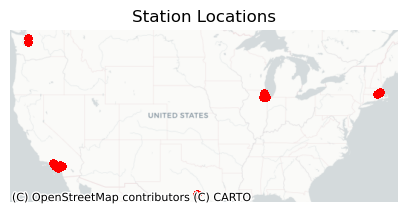

In [ ]:
# Step 1: Create a GeoDataFrame from the station coordinates
gdf_stations = gpd.GeoDataFrame(
    amazon_df,  # your transposed dataframe with 'station' column
    geometry=amazon_df['station'].apply(lambda coord: Point(coord[1], coord[0])),  # (lng, lat)
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

# Step 2: Project to Web Mercator for compatibility with basemap
gdf_stations = gdf_stations.to_crs(epsg=3857)

# Step 3: Plot
fig, ax = plt.subplots(figsize=(6, 6))
gdf_stations.plot(ax=ax, color='red', markersize=20)

# Step 4: Add basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Optional: remove axis
ax.set_axis_off()

plt.title("Station Locations")
plt.show()


In [32]:
bbox_illinois = {
    'lat_min': 40.5,   # includes southern Illinois & some of Indiana
    'lat_max': 43.0,
    'lon_min': -91.0,  # includes areas west of Illinois
    'lon_max': -86.0   # includes Indiana
}

bbox_california = {
    'lat_min': 32.0,
    'lat_max': 42.5,
    'lon_min': -125.0,
    'lon_max': -114.0
}

# Create lat/lon columns from the station tuple
amazon_df['lat'] = amazon_df['station'].apply(lambda x: x[0] if x is not None else None)
amazon_df['lon'] = amazon_df['station'].apply(lambda x: x[1] if x is not None else None)

# Illinois region (includes bordering areas)
df_illinois = amazon_df[
    (amazon_df['lat'] >= bbox_illinois['lat_min']) &
    (amazon_df['lat'] <= bbox_illinois['lat_max']) &
    (amazon_df['lon'] >= bbox_illinois['lon_min']) &
    (amazon_df['lon'] <= bbox_illinois['lon_max'])
]

# California region
df_california = amazon_df[
    (amazon_df['lat'] >= bbox_california['lat_min']) &
    (amazon_df['lat'] <= bbox_california['lat_max']) &
    (amazon_df['lon'] >= bbox_california['lon_min']) &
    (amazon_df['lon'] <= bbox_california['lon_max'])
]


In [33]:
df_illinois

,station_code,date_YYYY_MM_DD,departure_time_utc,executor_capacity_cm3,route_score,stops,station,dropoffs,lat,lon
RouteID_0036cf37-1c93-48f8-b337-3dd6d1a195d8,DCH4,2018-08-02,15:29:32,4247527.0,High,"{'AI': {'lat': 42.067241, 'lng': -87.981871, '...","(42.254346, -87.985697)","[(42.067241, -87.981871), (42.067738, -87.9842...",42.254346,-87.985697
RouteID_00747543-3f2f-47ae-a2f2-91b30ce207ab,DCH3,2018-08-08,15:30:00,3313071.0,High,"{'AA': {'lat': 41.642536, 'lng': -88.240729, '...","(41.803295, -88.097259)","[(41.642536, -88.240729), (41.633664, -88.2267...",41.803295,-88.097259
RouteID_0074e307-23c1-4b15-afa2-e58b45e4403c,DCH1,2018-08-03,13:41:51,3313071.0,Medium,"{'AC': {'lat': 41.831992, 'lng': -87.672874, '...","(41.840375, -87.683736)","[(41.831992, -87.672874), (41.825254, -87.6690...",41.840375,-87.683736
RouteID_00a25e47-65c9-4efc-bfe9-8d9648a0df4e,DCH2,2018-08-07,13:22:44,3313071.0,High,"{'AA': {'lat': 42.088807, 'lng': -87.706772, '...","(42.031368, -87.776596)","[(42.088807, -87.706772), (42.093276, -87.7086...",42.031368,-87.776596
RouteID_013e4370-df62-4c24-a19f-2971db140ca7,DCH4,2018-08-10,14:56:51,4247527.0,Medium,"{'AA': {'lat': 42.097677, 'lng': -88.049378, '...","(42.254346, -87.985697)","[(42.097677, -88.049378), (42.117006, -88.0649...",42.254346,-87.985697
...,...,...,...,...,...,...,...,...,...,...
RouteID_ff915688-4784-49a0-9ee6-f424f1768ca4,DCH3,2018-08-01,15:30:00,3313071.0,Medium,"{'AB': {'lat': 41.588026, 'lng': -88.190212, '...","(41.803295, -88.097259)","[(41.588026, -88.190212), (41.594653, -88.2096...",41.803295,-88.097259
RouteID_ffc2b0c3-917a-4041-8fdd-399ffbd0752f,DCH2,2018-07-27,12:39:10,3313071.0,Medium,"{'AK': {'lat': 41.929769, 'lng': -87.867893, '...","(42.031368, -87.776596)","[(41.929769, -87.867893), (41.922778, -87.8885...",42.031368,-87.776596
RouteID_ffe98097-93df-44b0-9c45-4fedbafae3f3,DCH4,2018-08-10,14:07:25,3313071.0,Medium,"{'AC': {'lat': 42.187711, 'lng': -88.262079, '...","(42.254346, -87.985697)","[(42.187711, -88.262079), (42.151021, -88.2765...",42.254346,-87.985697
RouteID_ffebb6fc-ce81-46db-b2a1-2750c0333185,DCH3,2018-07-25,14:10:26,3313071.0,High,"{'AA': {'lat': 41.858479, 'lng': -88.322974, '...","(41.803295, -88.097259)","[(41.858479, -88.322974), (41.834724, -88.3210...",41.803295,-88.097259


In [34]:
def explode_dropoffs(df_region):
    # Drop rows with missing or empty dropoffs
    df_filtered = df_region[df_region['dropoffs'].apply(lambda x: isinstance(x, list) and len(x) > 0)]

    # Explode dropoffs so each becomes a row
    exploded = df_filtered.explode('dropoffs')

    # Rename for clarity
    exploded = exploded[['station', 'dropoffs']].rename(columns={'dropoffs': 'dropoff'})

    return exploded.reset_index(drop=True)

# Apply to each region
df_illinois_exploded = explode_dropoffs(df_illinois)
df_california_exploded = explode_dropoffs(df_california)

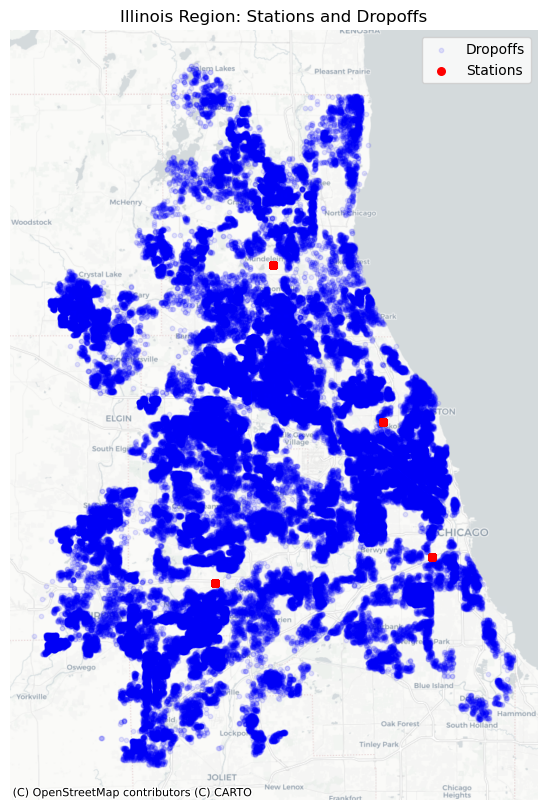

In [35]:
def plot_station_dropoffs(df_region_exploded, title):
    # Create GeoDataFrames for stations and dropoffs
    gdf_stations = gpd.GeoDataFrame(
        df_region_exploded,
        geometry=df_region_exploded['station'].apply(lambda coord: Point(coord[1], coord[0])),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    gdf_dropoffs = gpd.GeoDataFrame(
        df_region_exploded,
        geometry=df_region_exploded['dropoff'].apply(lambda coord: Point(coord[1], coord[0])),
        crs="EPSG:4326"
    ).to_crs(epsg=3857)

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf_dropoffs.plot(ax=ax, color='blue', markersize=10, alpha=0.1, label='Dropoffs')
    gdf_stations.plot(ax=ax, color='red', markersize=30, label='Stations')

    ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)
    ax.set_axis_off()
    ax.legend()
    plt.title(title)
    plt.show()

plot_station_dropoffs(df_illinois_exploded, title="Illinois Region: Stations and Dropoffs")

In [36]:
def process_od_model(df_exploded, h3_res=7):
    # Drop rows with invalid coordinates (0s or None)
    df = df_exploded.copy()
    df = df[df['station'].notnull() & df['dropoff'].notnull()]
    df = df[
        (df['station'].apply(lambda x: x[0] != 0 and x[1] != 0)) &
        (df['dropoff'].apply(lambda x: x[0] != 0 and x[1] != 0))
    ]

    # Assign H3 zones
    df['origin'] = df['station'].apply(lambda x: h3.latlng_to_cell(x[0], x[1], h3_res))
    df['destination'] = df['dropoff'].apply(lambda x: h3.latlng_to_cell(x[0], x[1], h3_res))

    # OD matrix (delivery counts)
    od_matrix = df.groupby(['origin', 'destination']).size().unstack(fill_value=0)
    hex_ids = list(set(od_matrix.index) | set(od_matrix.columns))

    # Centroids of hexes
    centroids = {h: h3.cell_to_latlng(h) for h in hex_ids}

    # Haversine distance
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # km
        dlat = radians(lat2 - lat1)
        dlon = radians(lon2 - lon1)
        lat1 = radians(lat1)
        lat2 = radians(lat2)
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        return 2 * R * atan2(sqrt(a), sqrt(1 - a))

    # Cost matrix
    n = len(hex_ids)
    cost_matrix = np.zeros((n, n))
    for i, h_i in enumerate(hex_ids):
        lat1, lon1 = centroids[h_i]
        for j, h_j in enumerate(hex_ids):
            lat2, lon2 = centroids[h_j]
            cost_matrix[i, j] = haversine(lat1, lon1, lat2, lon2)

    np.fill_diagonal(cost_matrix, 0.5)  # intra-zone cost

    cost_df = pd.DataFrame(cost_matrix, index=hex_ids, columns=hex_ids)

    # Flatten OD and cost to long format
    od_long = od_matrix.stack().rename('flow').reset_index()
    od_long.columns = ['origin', 'destination', 'flow']
    cost_long = cost_df.stack().rename('cost').reset_index()
    cost_long.columns = ['origin', 'destination', 'cost']

    df_model = pd.merge(od_long, cost_long, on=['origin', 'destination'])
    df_model = df_model[df_model['flow'] > 0]

    # Add marginals
    O = od_matrix.sum(axis=1).rename('O')
    D = od_matrix.sum(axis=0).rename('D')
    df_model = df_model.merge(O, left_on='origin', right_index=True)
    df_model = df_model.merge(D, left_on='destination', right_index=True)
    df_model['log_O'] = np.log(df_model['O'].replace(0, 1e-6))
    df_model['log_D'] = np.log(df_model['D'].replace(0, 1e-6))
    df_model['log_cost'] = np.log(df_model['cost'])

    # Poisson regression
    X = df_model[['log_O', 'log_D', 'log_cost']]
    model = sm.GLM(df_model['flow'], X, family=sm.families.Poisson())
    result = model.fit()
    print(result.summary())
    beta = result.params['log_cost']
    print(f'\nEstimated beta: {beta:.4f}')

    # IPF prediction
    O_vec = O.reindex(hex_ids, fill_value=0).replace(0, 1e-6).values
    D_vec = D.reindex(hex_ids, fill_value=0).replace(0, 1e-6).values
    cost_exp = np.exp(-beta * cost_matrix)

    A = np.ones_like(O_vec)
    B = np.ones_like(D_vec)

    for it in range(1000):
        A_prev, B_prev = A.copy(), B.copy()
        A = 1 / (cost_exp @ (B * D_vec))
        B = 1 / (cost_exp.T @ (A * O_vec))
        if np.allclose(A, A_prev, atol=1e-6) and np.allclose(B, B_prev, atol=1e-6):
            print(f'\nIPF converged in {it + 1} iterations.')
            break
    else:
        print('IPF did not converge.')

    T_hat = np.outer(A * O_vec, B * D_vec) * cost_exp
    T_hat_df = pd.DataFrame(T_hat, index=hex_ids, columns=hex_ids)

    print(f'\nObserved total flow: {od_matrix.values.sum():,.0f}')
    print(f'Predicted total flow: {T_hat_df.values.sum():,.0f}')

    return beta


In [37]:
process_od_model(df_illinois_exploded)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                   flow   No. Observations:                  974
Model:                            GLM   Df Residuals:                      971
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9708.5
Date:                Wed, 09 Jul 2025   Deviance:                       13449.
Time:                        21:51:32   Pearson chi2:                 9.21e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
log_O          0.0465      0.002     25.323      0.0

np.float64(-0.09876278668580339)

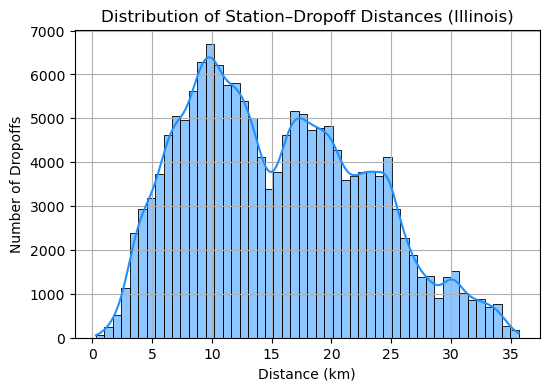

In [ ]:
def add_distances(df_exploded):
    df = df_exploded.copy()
    df['distance_km'] = df.apply(
        lambda row: haversine(
            row['station'][0], row['station'][1],
            row['dropoff'][0], row['dropoff'][1]
        ),
        axis=1
    )
    return df

df_illinois_dist = add_distances(df_illinois_exploded)

plt.figure(figsize=(6, 4))
sns.histplot(df_illinois_dist['distance_km'], bins=50, kde=True, color='dodgerblue')
plt.title('Distribution of Station–Dropoff Distances (Illinois)')
plt.xlabel('Distance (km)')
plt.ylabel('Number of Dropoffs')
plt.grid(True)
plt.show()